<a href="https://colab.research.google.com/github/holictoweb/python_finance_analysis/blob/master/backtrader/backtrader_BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 볼린저 밴드 계산과 매수/매도 전략

- 볼린저 밴드는 시간에 따른 특정 자산 가격과 변동성의 정보를 도출하는대 사용되는 통계적 방법 
- 밴드는 변동성이 증가하면 넓어지고 변동성이 감소하면 축소 
>>
지정된 윈도우 ( 20일... )를 사용해 시계열 (가격)의 이동 평균과 표준 편차를 계산
상/하한 밴드를 이동 평균 상/하의 표준 편차의 K배(일반적으로 2)로 설정



In [23]:
import pandas as pd
import datetime 
import backtrader as bt
from pprint import pprint 

In [27]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [28]:
data = bt.feeds.YahooFinanceData(
    dataname='MSFT',
    fromdate =datetime.datetime(2020,1,1),
    todate  = datetime.datetime(2020,12,31)
)

In [29]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open= True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)

cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [30]:
# backtest 실행

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 10000.00
2020-03-02, BUY CREATED --- Size: 61, Cash: 10000.00, Open: 163.65, Close: 171.05
2020-03-02, BUY EXECUTED --- Price: 163.65, Cost: 9982.65, Commission: 9.98
2020-05-13, SELL CREATED --- Size: 61
2020-05-13, SELL EXECUTED --- Price: 180.71, Cost: 9982.65, Commission: 11.02
2020-05-13, OPERATION RESULT --- Gross: 1040.66, Net: 1019.65
2020-10-30, BUY CREATED --- Size: 54, Cash: 11019.65, Open: 202.5, Close: 201.48
2020-10-30, BUY EXECUTED --- Price: 202.50, Cost: 10935.00, Commission: 10.94
2020-12-21, SELL CREATED --- Size: 54
2020-12-21, SELL EXECUTED --- Price: 217.05, Cost: 10935.00, Commission: 11.72
2020-12-21, OPERATION RESULT --- Gross: 785.70, Net: 763.04
Final Portfolio Value: 11782.70


<IPython.core.display.Javascript object>

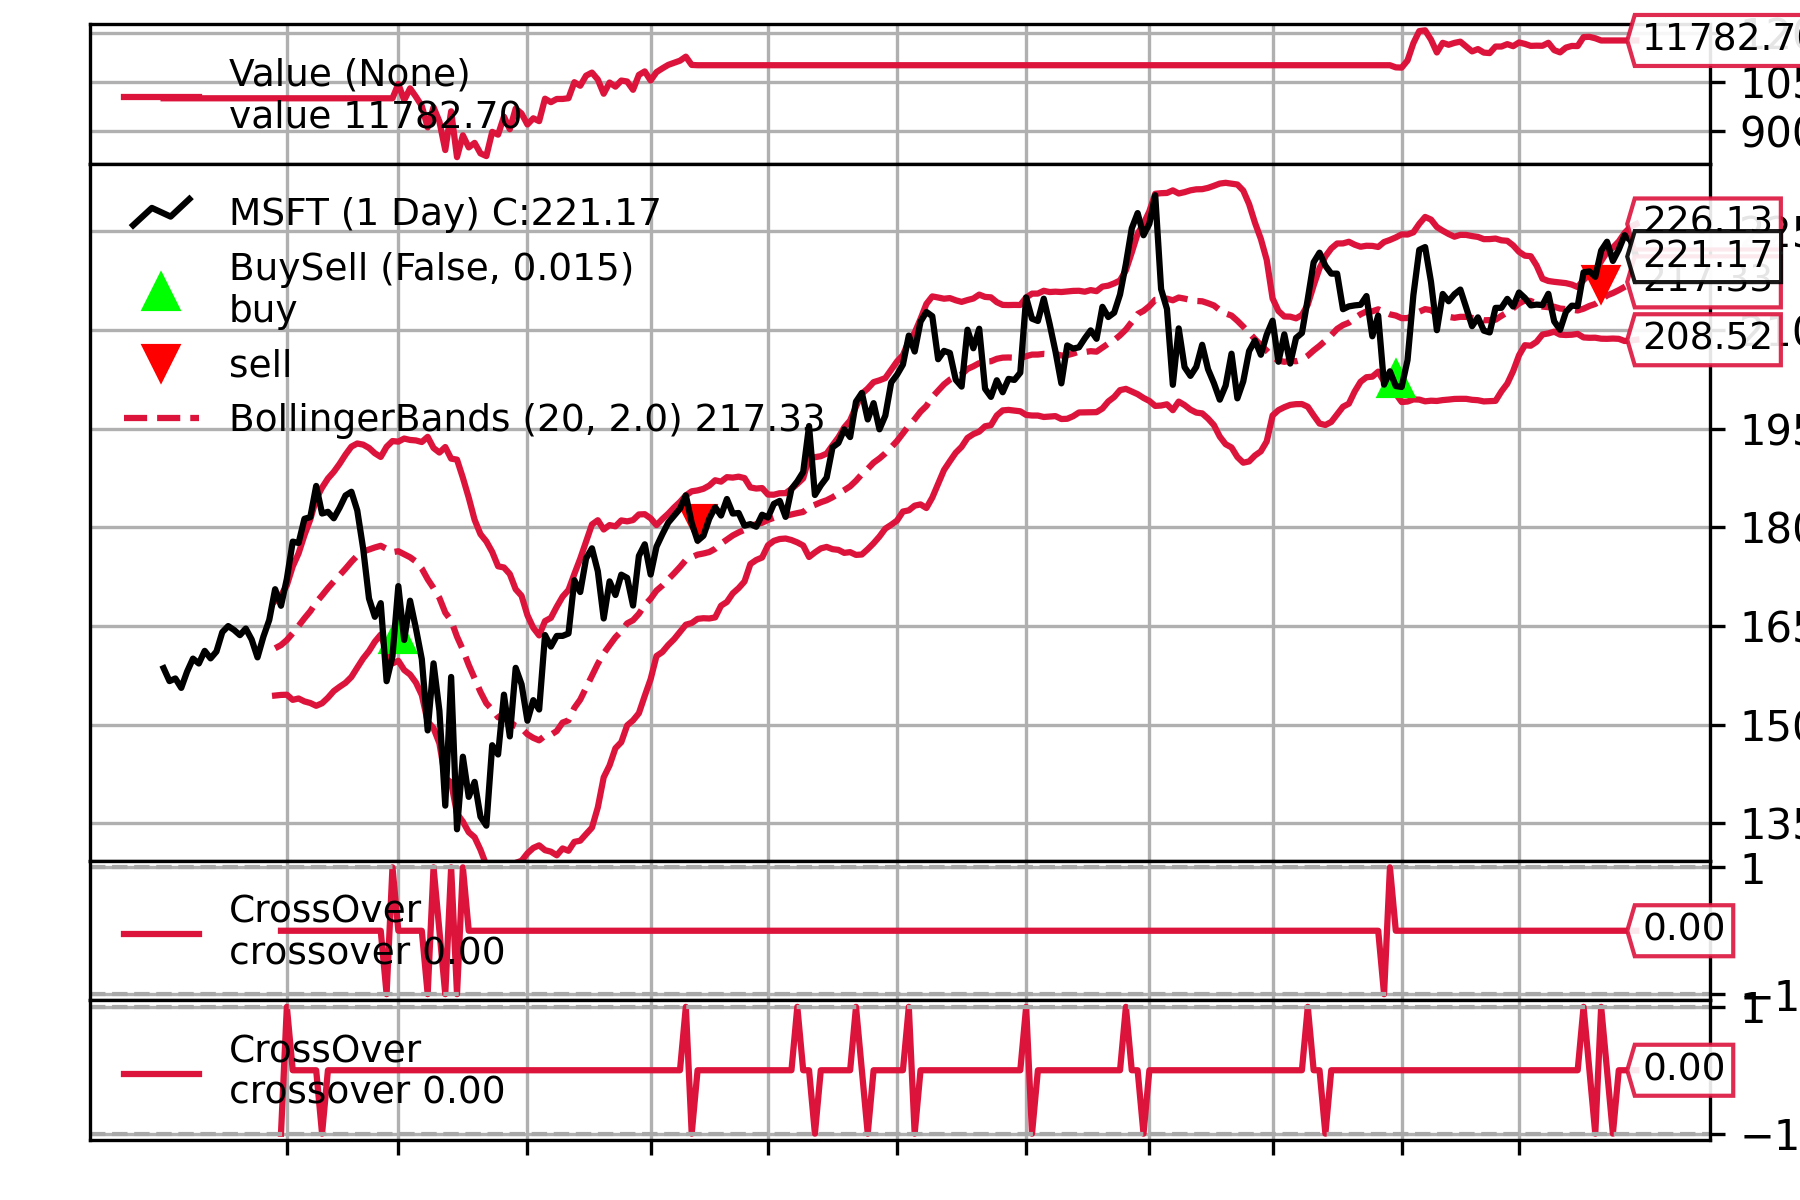

In [31]:
from google.colab import files
from IPython.display import Image
chart_file = 'result.png'
cerebro.plot(iplot=True, volume=False)[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())

#cerebro.plot(iplot=True, volume=False)

In [5]:
!pip install yfinance
!pip install backtrader

     |████████████████████████████████| 5.5MB 16.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=34004568c6974ef2933db4d4b250312ea8ee7055b9a89165bc86469f6eb7dd06
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 419kB 11.6MB/s 
